In [1]:
import numpy as np
from scipy import sparse
from time import time
import pandas as pd
import networkx as nx
import graph_tool as gt
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import regex as re
from pathlib import Path
from importlib import reload
from pprint import pp
from collections import Counter

In [2]:
import utils as u
import analysis as a

In [48]:
# Call to reload an imported module if it has been updated
reload(u)

<module 'utils' from '/home/rimov/Documents/Course Material/Assignments/m450/reddit-assortativity-analysis/utils.py'>

In [3]:
%matplotlib notebook
plt.rcParams.update({'axes.titlesize': 'large'})
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
data_path = Path('data/chain_networks')
data_path.exists()

True

In [5]:
subreds_raw = dict()

In [6]:
# All the subreddits and their paths
subreddits_paths = [sr for sr in data_path.iterdir()]
subreddits = [sr.stem for sr in data_path.iterdir()]
print(sorted(subreddits)[:5], '...', sorted(subreddits)[-5:])

['2007scape', '240sx', '24hoursupport', '3DS', '3Dprinting'] ... ['youtubehaiku', 'yugioh', 'zelda', 'zen', 'zombies']


#### Non-political Subreddits by Group:
Analysis of political subreddits must be compared to other groups in order to observe any trends. Ideally I would find a group of subreddits that are as closely resembling of natural social groups as possible, so as to perhaps show that advice-giving subreddits or those dealing with sensitive topics (eg. politics, sports) show great homophilic tendincies or high betweenness. This would support the hypothesis that reddit is not a great place to turn to for advice or gaining perspective, as the communities that purport to do that are biased.

The groups chosen to be sampled are those related to: 
<ul>
    <li>gaming: 
        <ul>
            <li>CrusaderKings</li>
            <li>Diablo</li>
            <li>GTAV</li>
            <li>2007scape</li>
            <li>HalfLife</li>
        </ul>
    </li>
    <li>geographical(dedicated to specific cities/countries): 
        <ul>
            <li>Amsterdam</li>
            <li>Brooklyn</li>
            <li>Hawaii</li>
            <li>Israel</li>
            <li>LosAngeles</li>
        </ul>
    </li>
    <li>medicine(dedicated to certain mental or physical conditions): 
        <ul>
            <li>ChronicPain</li>
            <li>Fibromyalgia</li>
            <li>alcoholism</li>
            <li>bipolar</li>
            <li>socialanxiety</li>
        </ul>
    </li>
    <li>sports: 
        <ul>
            <li>Bowling</li>
            <li>Kayaking</li>
            <li>nyjets</li>
            <li>powerlifting</li>
            <li>lacrosse</li>
        </ul>
    </li>
    <li>religion: 
        <ul>
            <li>Catholicism</li>
            <li>Christianity</li>
            <li>Buddhism</li>
            <li>Judaism</li>
            <li>islam</li>
        </ul>
    </li>
    <li>QA/advice: 
        <ul>
            <li>AskEngineers</li>
            <li>askphilosophy</li>
            <li>AskFeminists</li>
            <li>AskNYC</li>
            <li>AskPhotography</li>
        </ul>
    </li>
</ul>

Each group will have at most 5 subreddits, as combing through ~2000 subreddits and partitioning each is very time-consuming. Choosing of the subreddits was done by simply scrolling through an alphabetically-ordered list and choosing based on recognition or personal preference (thought subreddit X was more representative of the selected group than subreddit Y) -- therefore the choice was not random and **is biased**. Analyzing subreddits with >1 million members would be too computationally-demanding to perform calculations on, so I restricted focus to the smaller ones, which could be a bit more niche and perhaps in some way bias the results.

In [8]:
topics_game = ['CrusaderKings', 'Diablo', 'GTAV', '2007scape', 'HalfLife']
topics_geo = ['Amsterdam', 'Brooklyn', 'Hawaii', 'Israel', 'LosAngeles']
topics_med = ['ChronicPain', 'Fibromyalgia', 'alcoholism', 'bipolar', 'socialanxiety']
topics_sport = ['Bowling', 'Kayaking', 'nyjets', 'powerlifting', 'lacrosse']
topics_religion = ['Catholicism', 'Christianity', 'Buddhism', 'Judaism', 'islam']
topics_ask = ['AskEngineers', 'askphilosophy', 'AskFeminists', 'AskNYC', 'AskPhotography']

In [9]:
paths_game = [data_path/f'{topic}.json' for topic in topics_game]
paths_geo = [data_path/f'{topic}.json' for topic in topics_geo]
paths_med = [data_path/f'{topic}.json' for topic in topics_med]
paths_sport = [data_path/f'{topic}.json' for topic in topics_sport]
paths_religion = [data_path/f'{topic}.json' for topic in topics_religion]
paths_ask = [data_path/f'{topic}.json' for topic in topics_ask]

In [10]:
group_paths = {'game': paths_game, 'geo': paths_geo, 'med': paths_med, 'sport': paths_sport, 'religion': paths_religion, 'ask': paths_ask}
all_paths = {p.stem: p for p in [*paths_game, *paths_geo, *paths_med, *paths_sport, *paths_religion, *paths_ask]}

In [11]:
paths_valid = []

for ps in group_paths.values():
    paths_valid.append([(sr.stem, sr in subreddits_paths) for sr in ps])
    
paths_valid

[[('CrusaderKings', True),
  ('Diablo', True),
  ('GTAV', True),
  ('2007scape', True),
  ('HalfLife', True)],
 [('Amsterdam', True),
  ('Brooklyn', True),
  ('Hawaii', True),
  ('Israel', True),
  ('LosAngeles', True)],
 [('ChronicPain', True),
  ('Fibromyalgia', True),
  ('alcoholism', True),
  ('bipolar', True),
  ('socialanxiety', True)],
 [('Bowling', True),
  ('Kayaking', True),
  ('nyjets', True),
  ('powerlifting', True),
  ('lacrosse', True)],
 [('Catholicism', True),
  ('Christianity', True),
  ('Buddhism', True),
  ('Judaism', True),
  ('islam', True)],
 [('AskEngineers', True),
  ('askphilosophy', True),
  ('AskFeminists', True),
  ('AskNYC', True),
  ('AskPhotography', True)]]

In [12]:
all([p[1] for p in paths_valid])

True

## Surface Analysis:
Will do this a group at a time to not overload the RAM.

### Cosine similarity

Notice that mean similarity is heavily skewed by edge scores and also doesn't imply what type of similarity you are observing -- eg. you can have a bunch of 1 degree nodes with edges to a single node, which will all be identical to eachother according to cosine similarity, skewing network mean similarity. 

Thus keep in mind that large node-betweenness probably is directly proportional to high cosine similarity.

In [13]:
test_points = {
    1: [2,6],
    2: [3],
    3: [2,4,7],
    4: [],
    5: [6],
    6: [1],
    7: [2,6,11],
    8: [4],
    9: [2,6,11],
    10: [7],
    11: [8,13,14],
    12: [8],
    13: [],
    14: [],
}

In [55]:
plt.clf()

In [14]:
test_net = nx.DiGraph(test_points)

In [15]:
csim = a.node_mean_cosine_similarity(test_net)
csim

1     0.000000
2     0.154587
3     0.000000
4     0.060968
5     0.000000
6     0.104079
7     0.060968
8     0.101015
9     0.000000
10    0.000000
11    0.101015
12    0.000000
13    0.121936
14    0.121936
dtype: float64

In [16]:
csim.mean()

0.05903606026461977

________________________________________________________________

### Assortativity (Largest strongly-connected component vs not)

Looking at assortativity between largest strongly-connected component and those outside of it. The reason for this split, is the idea that if there is little communication between the component and "outsider" nodes -- and nodes in these networks represent top 20% of active users in the subreddit -- then new users will get replies from either group and not both.

In [17]:
modularity = a.graph_strongest_vs_not_assortativity(
    dict(u.digraph_from_path(n, p) for n,p in all_paths.items())
)
modularity

CrusaderKings     0.179617
Diablo            0.137987
GTAV              0.245375
2007scape         0.133760
HalfLife          0.243362
Amsterdam         0.188082
Brooklyn          0.234454
Hawaii            0.191843
Israel            0.159176
LosAngeles        0.203405
ChronicPain       0.231974
Fibromyalgia      0.238290
alcoholism        0.096921
bipolar           0.240577
socialanxiety     0.164635
Bowling           0.232951
Kayaking          0.119294
nyjets            0.154460
powerlifting      0.244622
lacrosse          0.224287
Catholicism       0.167104
Christianity      0.175410
Buddhism          0.217717
Judaism           0.186464
islam             0.177624
AskEngineers      0.223112
askphilosophy     0.205613
AskFeminists      0.205412
AskNYC            0.181103
AskPhotography    0.165490
Name: modularity, dtype: float64

### Visualizing Differences

In [69]:
subreddit_params = pd.DataFrame()

In [70]:
for name, path in group_paths.items():
    nets = dict([u.digraph_from_path(p.stem, p) for p in path])
    sr_group = [name]*len(nets)
    params = a.get_graph_base_stats(nets)
    params.insert(0, 'group', sr_group)
    
    subreddit_params = pd.concat([subreddit_params, params], axis=0)

In [71]:
subreddit_params

,group,nodes,edges,density,nodes_largest_strong_comp,pct_nodes_largest_strong_comp,nodes_deg_one,pct_nodes_deg_one,pagerank_max,pagerank_avg,reciprocity,mean_cos_sim,modularity
CrusaderKings,game,7738,26367,0.000440,2394,0.309382,1612,0.208323,0.008198,0.000129,0.151553,0.000528,0.179617
Diablo,game,32420,107055,0.000102,10522,0.324553,6843,0.211073,0.008867,0.000031,0.098024,0.000136,0.137987
GTAV,game,8470,19440,0.000271,1902,0.224557,2334,0.275561,0.006093,0.000118,0.203909,0.000322,0.245375
2007scape,game,13285,58847,0.000333,4316,0.324878,3025,0.227700,0.007487,0.000075,0.177375,0.000478,0.133760
HalfLife,game,2844,6115,0.000756,463,0.162799,803,0.282349,0.023426,0.000352,0.156664,0.000683,0.243362
Amsterdam,geo,1820,3987,0.001204,225,0.123626,498,0.273626,0.046887,0.000549,0.183095,0.000855,0.188082
Brooklyn,geo,2174,4424,0.000936,406,0.186753,613,0.281969,0.010847,0.000460,0.173146,0.000638,0.234454
Hawaii,geo,2103,5401,0.001222,435,0.206847,575,0.273419,0.022744,0.000476,0.163673,0.000998,0.191843
Israel,geo,4222,15575,0.000874,1200,0.284225,933,0.220985,0.014523,0.000237,0.191332,0.000940,0.159176
LosAngeles,geo,11891,30566,0.000216,2241,0.188462,3075,0.258599,0.008429,0.000084,0.144016,0.000195,0.203405


In [72]:
# Normalize the base stats for each subreddit relative to total sum 
#   across all the subreddits in the group
normalized_params = a.z_normalize(subreddit_params, sort_by=['density'])
normalized_params = normalized_params.sort_values(
    by=['group', 'pagerank_max'], ascending=False
)
normalized_params

,group,nodes,edges,density,nodes_largest_strong_comp,pct_nodes_largest_strong_comp,nodes_deg_one,pct_nodes_deg_one,pagerank_max,pagerank_avg,reciprocity,mean_cos_sim,modularity
Bowling,sport,-0.643696,-0.585065,1.613901,-0.504361,0.463136,-0.732727,-0.816751,-0.023240,1.494318,-0.181482,1.184210,1.008917
Kayaking,sport,-0.555942,-0.576087,0.046838,-0.597283,-2.051464,-0.516059,1.736002,-0.054857,0.566500,0.469485,-0.298300,-1.814532
lacrosse,sport,-0.518851,-0.537852,0.041485,-0.469999,-0.390963,-0.527538,0.534101,-0.114606,0.339160,-1.103051,0.049203,0.793686
powerlifting,sport,-0.402902,-0.409109,-0.069588,-0.355298,0.092186,-0.450771,-0.394123,-0.347912,-0.108152,0.828843,0.272785,1.298834
nyjets,sport,-0.395815,-0.318927,0.268983,-0.273023,0.840509,-0.383331,0.352488,-0.371652,-0.127484,-0.271549,0.586254,-0.940945
Judaism,religion,-0.460047,-0.352307,0.711936,-0.401275,0.013824,-0.535430,-0.705299,0.702125,0.075873,0.931392,0.874394,-0.145904
Buddhism,religion,-0.013741,-0.104001,-0.659745,-0.188329,-0.410746,0.093770,0.335918,-0.290421,-0.664092,0.413279,-0.403836,0.630465
Catholicism,religion,-0.207190,-0.068949,-0.077617,-0.162194,0.486807,-0.286476,-0.858260,-0.414263,-0.476593,1.217279,0.385915,-0.626830
islam,religion,0.081551,0.212940,-0.505849,0.112216,0.707294,0.001220,-0.907501,-0.576859,-0.726737,1.077050,-0.040790,-0.365505
Christianity,religion,2.193965,2.757652,-1.069243,1.580096,0.305515,1.903168,-1.335247,-1.081817,-1.096833,0.632198,-1.013992,-0.420502


In [73]:
exclude_cols = ['nodes_largest_strong_comp', 'nodes_deg_one', 'group']
include = [c not in exclude_cols for c in subreddit_params.columns]

In [74]:
plt.clf()

# TODO: Assortativity (Agglomerative Heuristic)

Use modularity maximization algorithm to partition networks into communities. Then calculate the modularity based on the extracted communities. Keeping track of amount of communities detected as might be potentially useful.

Time-consuming in Networkx; saving for further analysis down the line.

In [49]:
communities = dict()

In [50]:
for sr, path in all_paths.items():
    print(f'Getting communities for: {sr}')
    _, net = u.digraph_from_path(sr, path)
    
    communities[sr] = nx.algorithms.community.louvain.louvain_communities(
        net, 
        resolution=resolution,
        threshold=threshold,
        seed=seed
    )

Getting communities for: CrusaderKings
Getting communities for: Diablo


KeyboardInterrupt: 

______________________________________________________________________

<IPython.core.display.Javascript object>


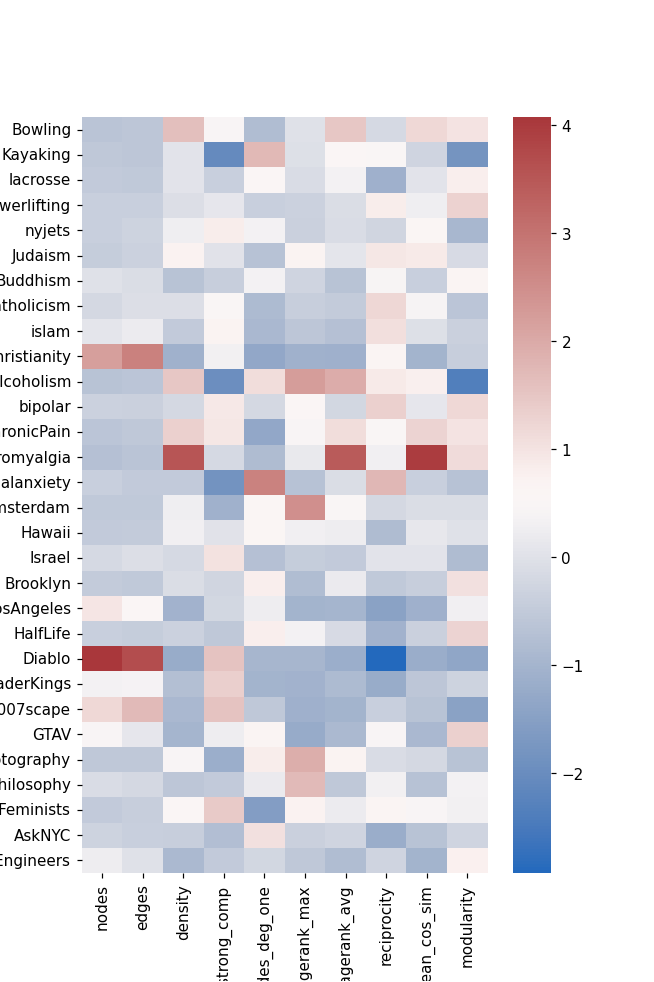

In [75]:
fig, ax = plt.subplots(figsize=(6,9))

In [76]:
plt.cla()
sns.heatmap(normalized_params.loc[:, include], cmap=sns.color_palette("vlag", as_cmap=True))

<AxesSubplot: >

In [77]:
plt.savefig('images/base-stats-znormalized.png', bbox_inches='tight')

In [86]:
group_params = normalized_params.groupby(['group']).mean().drop(['nodes_largest_strong_comp', 'nodes_deg_one'], axis=1)
group_params

,nodes,edges,density,pct_nodes_largest_strong_comp,pct_nodes_deg_one,pagerank_max,pagerank_avg,reciprocity,mean_cos_sim,modularity
group,,,,,,,,,,
ask,-0.254505,-0.324713,-0.180928,-0.305864,0.042320,0.683679,-0.155541,-0.127490,-0.424309,0.094614
game,1.136914,1.074717,-0.845224,0.822197,-0.219345,-0.801178,-0.811494,-1.028814,-0.746429,-0.107243
geo,-0.146125,-0.213704,-0.162728,-0.106339,0.299875,0.098096,-0.120449,-0.596905,-0.294142,0.075886
med,-0.551751,-0.539958,1.128660,-0.421214,0.288885,0.534104,1.232292,0.950522,1.145710,0.053207
religion,0.318908,0.489067,-0.320104,0.220539,-0.694078,-0.332247,-0.577676,0.854239,-0.039662,-0.185655
sport,-0.503441,-0.485408,0.380324,-0.209319,0.282343,-0.182453,0.432868,-0.051551,0.358830,0.069192


In [94]:
param_summ = pd.concat([subreddit_params.mean(), subreddit_params.median(), subreddit_params.std()], axis=1, keys=['mean', 'median', 'stdev'])
param_summ

/tmp/ipykernel_19584/124432436.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  param_summ = pd.concat([subreddit_params.mean(), subreddit_params.median(), subreddit_params.std()], axis=1, keys=['mean', 'median', 'stdev'])
/tmp/ipykernel_19584/124432436.py:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  param_summ = pd.concat([subreddit_params.mean(), subreddit_params.median(), subreddit_params.std()], axis=1, keys=['mean', 'median', 'stdev'])
/tmp/ipykernel_19584/124432436.py:1: FutureWarning: The default value of numeric_o

,mean,median,stdev
nodes,5411.133333,2815.000000,6632.223748
edges,17227.666667,7853.500000,24506.117529
density,0.001012,0.000905,0.000747
nodes_largest_strong_comp,1318.133333,630.500000,2066.246301
pct_nodes_largest_strong_comp,0.206143,0.207025,0.076735
nodes_deg_one,1269.300000,773.500000,1393.833616
pct_nodes_deg_one,0.249754,0.249218,0.039903
pagerank_max,0.019609,0.016105,0.010977
pagerank_avg,0.000400,0.000355,0.000319
reciprocity,0.189776,0.195056,0.031366


<IPython.core.display.Javascript object>


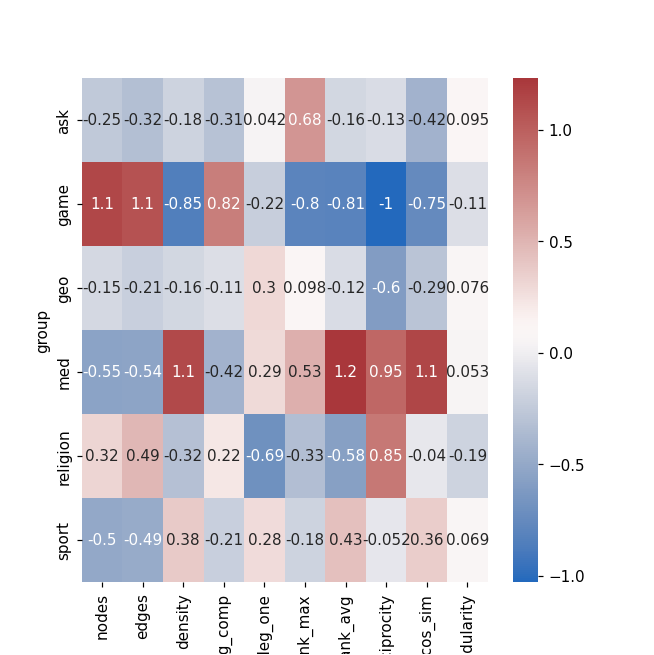

In [83]:
fig,ax = plt.subplots(figsize=(6,6))

In [84]:
# fig.delaxes(fig.axes[1])
plt.cla()
sns.heatmap(group_params, cmap=sns.color_palette("vlag", as_cmap=True), annot=True)

<AxesSubplot: ylabel='group'>

### NOTE:
A pattern of group behavior seems to be emerging:
<ul>
    <li>
        sports:
        <ul>
            <li>seems most average of the groups</li>
        </ul>
    </li>
    <li>
        religion:
        <ul>
            <li>higher reciprocity</li>
            <li>normally distrib pagerank</li>
            <li>lower pagerank</li>
            <li></li>
        </ul>
    </li>
    <li>
        med:
        <ul>
            <li>high density</li>
            <li>strongest comp high variance?</li>
            <li>higher pagerank max, high pagerank average</li>
            <li>higher reciprocity</li>
        </ul>
    </li>
    <li>
        geo:
        <ul>
            <li></li>
            <li></li>
            <li></li>
            <li></li>
        </ul>
    </li>
    <li>
        games:
        <ul>
            <li></li>
            <li></li>
            <li></li>
            <li></li>
        </ul>
    </li>
    <li>
        ask:
        <ul>
            <li></li>
            <li></li>
            <li></li>
            <li></li>
        </ul>
    </li>
    <li>NOTE: some stats could be influenced by size of communities (alcoholism), check for that</li>
    <li>NOTE: percent largest strongly-connected component and degree one nodes are basically inverse values</li>
</ul>

## Random Graphs: